In [56]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.insert(0, '/home/frieren/Documents/projects/icenumerics/')
sys.path.insert(0,'../auxnumerics/')
sys.path.insert(0, '../')
import icenumerics as ice
from parameters import params
import vertices as vrt

%reload_ext autoreload
%autoreload 2

ureg = ice.ureg
idx = pd.IndexSlice

In [ ]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

In [2]:
def geometrical_part(r,B):
    """ 
        Geometrical part of the force 
        (rxB)xB - 2r + 5r (rxB)^2
    """
    rcb = np.cross(r,B)
    return 2*np.cross(rcb,B) - 2*r + 5*r*np.dot(rcb,rcb)

def get_forces(params, positions, Bhat = [1,0,0]):
    """
        Compute the total force on all the particles
    """
    
    # get the dimensional part in pN * nm
    factor = (3*params['mu0']*params['m']**2)/(4*np.pi)
    factor = factor.to(ureg.piconewton * ureg.micrometer**4)
    
    forces = [] # init
    
    # loop all particles
    for i,r1 in enumerate(positions):

        force = np.array([0,0,0])*ureg.piconewton

        # get the contribution from all particles to particle i
        for j,r2 in enumerate(positions):

            R = r1 - r2 
            distance = np.linalg.norm(R)
            
            # the algorithm eventually gets to itself, 
            # so I just want to skip this case
            if distance == 0:
                continue

            rhat = R/distance 
            distance = distance*ureg.um
            force = force + factor/distance**4 * geometrical_part(rhat,Bhat)

        forces.append(force.magnitude) 
    return np.asarray(forces)

In [62]:
def import_and_correct(params,filepath):
    """ Imports the trj and corrects the dx dy dz to include the trap sep """
    trj = vrt.trj2trj( pd.read_csv(filepath,index_col=['id']) )
    trj[['dx','dy','dz']] = trj[['dx','dy','dz']].apply(lambda x: params['trap_sep'].magnitude*x)
    return trj

def get_positions(trj):
    """ Gets a matrix where each row contains [x,y,z] for particle i """
    x = (trj['x'] + trj['cx']).to_numpy()
    y = (trj['y'] + trj['cy']).to_numpy()
    z = (trj['z'] + trj['cz']).to_numpy()
    return  np.vstack([x,y,z]).T

def forces_elements(params, positions, Bhat):
    """ Compute the forces and returns the directions and magnitudes """
    forces = get_forces(params,positions, Bhat=Bhat)
    fdirs = np.asarray([f/np.linalg.norm(f) for f in forces])
    mags = np.round( np.array([np.linalg.norm(f) for f in forces]),4)

    return fdirs, mags

In [125]:
a = params["lattice_constant"]
N=5

sp = ice.spins()
sp.create_lattice("square",[N,3],lattice_constant=a, border="periodic")


particle = ice.particle(radius = params["particle_radius"],
            susceptibility = params["particle_susceptibility"],
            diffusion = params["particle_diffusion"],
            temperature = params["particle_temperature"],
            density = params["particle_density"]
            )


trap = ice.trap(trap_sep = params["trap_sep"],
            height = params["trap_height"],
            stiffness = params["trap_stiffness"]
            )


col = ice.colloidal_ice(sp, particle, trap,
                        height_spread = params["height_spread"], 
                        susceptibility_spread = params["susceptibility_spread"],
                        periodic = params["isperiodic"])


col.randomize()
col.region = np.array([[0,0,-3*(params["particle_radius"]/a/N).magnitude],[1,1,3*(params["particle_radius"]/a/N).magnitude]])*N*a


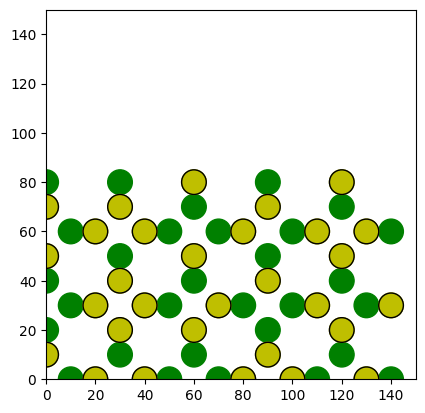

In [126]:
col.display()

In [120]:
col.to_ctrj().round().to_csv('/home/frieren/Dropbox/mnt/thesis/src/vertex_configs/3b20.csv')

In [15]:
DRIVE = '/home/frieren/Dropbox/'
PROJECT = 'mnt/thesis/src/vertex_configs'

Testing to get the forces in a single vertex

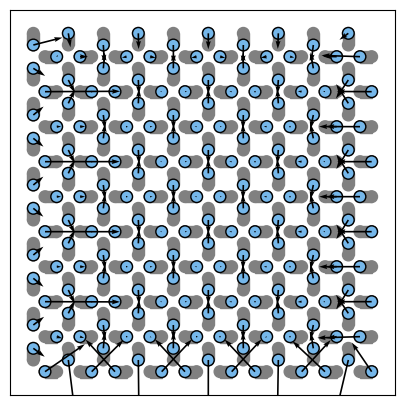

In [128]:
# import and correct a file
trj = import_and_correct(params,os.path.join(DRIVE,PROJECT,'10.csv'))

# compute the forces
pos = get_positions(trj)
force_dir, force_mag = forces_elements(params,pos,[1,0,0])
forces = force_dir * force_mag[:,np.newaxis]

# plot the figure
fig, ax = plt.subplots(figsize=(5,5))
ice.draw_frame(trj, frame_no=0,
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

# plot the forces
ax.quiver(pos[:,0],pos[:,1],forces[:,0],forces[:,1])

plt.show()

Now to get the forces on all of the single-vertices.\

Here I want to compute all of the forces first, and then normalize to a common scale where the maximum force is 1. 

Using this, we will be able to compare the single vertex forces correctly.

In [103]:
trj = pd.read_csv(os.path.join(DRIVE,PROJECT,'long1d.csv'),index_col='id')
trj.sort_values(by=['y','x']).to_csv(os.path.join(DRIVE,PROJECT,'long1d.csv'))